Описание: https://github.com/machine-intelligence-laboratory/MILTestTasks/tree/task/human_segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
import numpy as np

from torch.utils import data
from lib import *
import torch
from glob import glob
import csv
import os

%matplotlib inline

Для данного задания был выбран Unet, как наиболее простая для реализации сеть, не требующая выгрузки предобученных весов (может быть обучена с нуля). На данный момент SOTA для задачи сегментации является BEIT, основанный на Attention, но его реализация from scratch требует больших трудозатрат, а дообучение невозможно без выгрузки предобученной модели. Обучение с нуля такого рода моделей не представляется возможным. По ощущениям, модели не дообучены, но на большее число итераций, к сожалению, не хватило времени и ресурсов. Проверка на pep8 не делалась, тк в изначальном репозитории уже были несоответствия этому стандарту. Разница между моделями хотя и есть, но не является большой. Лучше всего показала себя модель, обученная на данных с небольшой аугментацией.

## Data

In [ ]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4

In [ ]:
train_path = 
train_mask_path = 
valid_path = 
valid_mask_path = 
test_path = 

In [ ]:
X_train_aug = get_data(train_path, train_mask_path, train_aug)
X_valid_aug = get_data(valid_path, valid_mask_path, valid_aug)

In [ ]:
X_train = get_data(train_path, train_mask_path, train_initial_aug)
X_valid = get_data(valid_path, valid_mask_path, valid_initial_aug)

In [ ]:
train_loader = data.DataLoader(X_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(X_valid, batch_size=VAL_BATCH_SIZE, shuffle=True)
train_loader_aug = data.DataLoader(X_train_aug, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader_aug = data.DataLoader(X_train_aug, batch_size=VAL_BATCH_SIZE, shuffle=True)

## Training

In [ ]:
cuda = torch.device('cuda')

In [ ]:
IN_CHANELS = 3
OUT_CHANELS = 1

In [24]:
LR = 0.01
EPOCHS = 20

Epoch 19... Train Loss: 0.097
Epoch 19... Eval Loss: 0.917


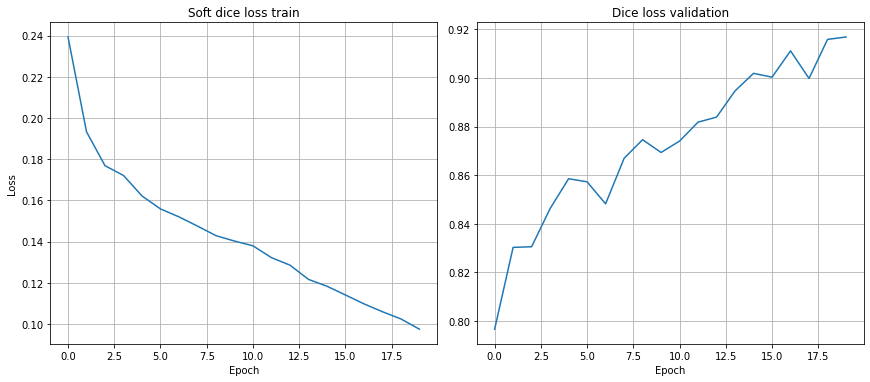




100%|██████████| 20/20 [1:49:59<00:00, 329.97s/it]


In [25]:
# model with aug

model = UNet(IN_CHANELS, OUT_CHANELS).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
val_res_initial = train(model, train_loader_aug, val_loader_aug, EPOCHS, optimizer, soft_dice_loss, get_dice)

Epoch 14... Train Loss: 0.120
Epoch 14... Eval Loss: 0.898


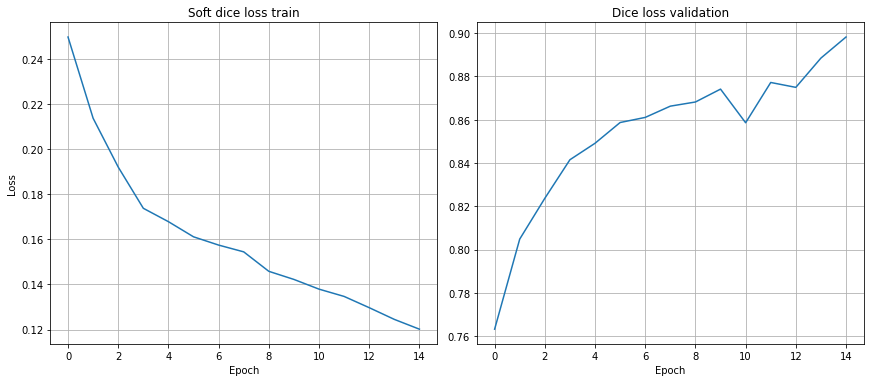

100%|██████████| 15/15 [1:19:29<00:00, 317.98s/it]


In [ ]:
# model with aug and upsample
model = UNet(IN_CHANELS, OUT_CHANELS, True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
val_res_with_upsample = train(model, train_loader_aug, val_loader_aug, EPOCHS, optimizer, soft_dice_loss, get_dice)

Epoch 14... Train Loss: 0.130
Epoch 14... Eval Loss: 0.883


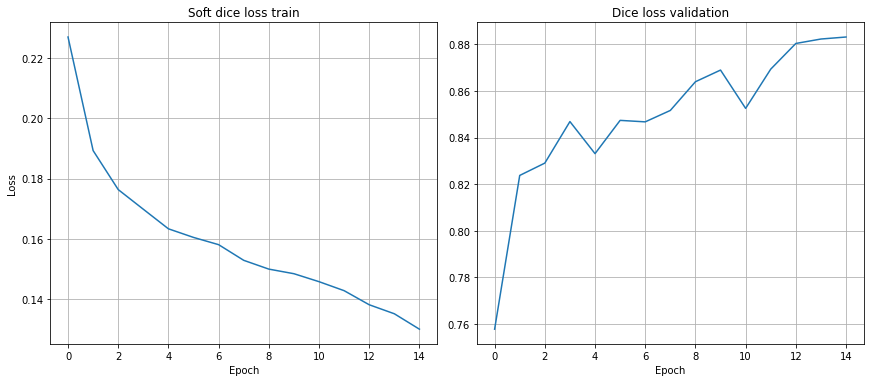

100%|██████████| 15/15 [1:00:39<00:00, 242.65s/it]


In [ ]:
model = UNet(IN_CHANELS, OUT_CHANELS).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
val_res_with_aug = train(model, train_loader_aug, val_loader, EPOCHS, optimizer, soft_dice_loss, get_dice)

## Inference

In [ ]:
dtype = torch.FloatTensor

In [30]:
X_test = get_data(test_path, None, valid_aug)
test_loader = data.DataLoader(X_test, batch_size=1, shuffle=False)
result = []
for X intest_loader:
  res = model(X.type(dtype).cuda())
  result.append(np.where(torch.squeeze(res).cpu().detach().numpy() > 0.5, 255, 0).astype(np.uint8))
_ = get_html(glob(test_path + '/*'), result, path_to_save="results/examples")

In [44]:
valid_loader = data.DataLoader(X_valid, batch_size=1, shuffle=False)
indexes = []
for X, _ in valid_loader:
  res = model(X.type(dtype).cuda())
  indexes.append(np.where(torch.squeeze(res).cpu().detach().numpy() > 0.5, 1, 0).astype(np.float))
masks = []
images = os.listdir(valid_path)
for i, k in enumerate(images):
    ind = k.split(".")[0]
    masks.append(encode_rle(result[i]))
with open('output.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "rle_mask"])
    writer.writerows(zip(indexes, masks))